In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import random
import numpy as np
from numpy import ndarray
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle

from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, Softmax, 
                           Lambda)
#from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.activations import tanh

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#import np_utils
from tensorflow.keras.utils import to_categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
import csv
from progressbar import ProgressBar
import seaborn as sns
from tensorflow import random as randomtf
from tensorflow.keras.backend import argmax as argmax

from tensorflow import one_hot
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from sklearn.metrics import r2_score

randomtf.set_seed(1)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
import matplotlib as mpl
from matplotlib import rc, rcParams

# import general file from utils as shared packages
import sys
sys.path.append("./../utils/")
from general import *

2023-06-13 13:40:50.346785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 13:40:50.411043: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 13:40:50.742103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-06-13 13:40:50.742146: W tensorflow/compile

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-06-13 13:40:52.949518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 13:40:52.959299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 13:40:52.963880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 13:40:52.964005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

2023-06-13 13:40:53.250225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 13:40:53.250389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 13:40:53.250454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-13 13:40:53.250508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Text(0.5, 0, '!!!Ariaaaal')

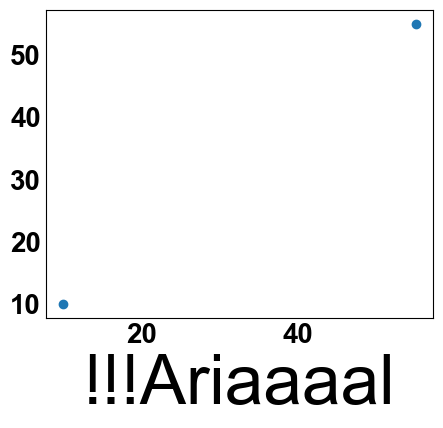

In [3]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [4]:
tf.compat.v1.keras.backend.clear_session()
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [5]:
with open('./../data/trainingsets/highgap_outliergen_trans1/image.pickle', 'rb') as f:
    X_smiles_gen, SMILES_gen, y_gen = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_train.pickle', 'rb') as f:
    X_smiles_train_gen, SMILES_train_gen, y_train_gen = pickle.load(f)
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_test.pickle', 'rb') as f:
    X_smiles_test_gen, SMILES_test_gen, y_test_gen = pickle.load(f)

In [6]:
SMILES_gen = np.array (SMILES_gen)
y_gen = np.array (y_gen)

In [7]:
with open('./../data/trainingsets/highgap_pubqc/image.pickle', 'rb') as f:
    X_smiles_pubqc, SMILES_pubqc, y_pubqc = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train_pubqc, SMILES_train_pubqc, y_train_pubqc = pickle.load(f) 
    
with open('./../data/trainingsets/highgap_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_test_pubqc, SMILES_test_pubqc, y_test_pubqc = pickle.load(f) 

In [8]:
X_smiles = np.concatenate ((X_smiles_pubqc, X_smiles_gen), axis=0)
SMILES = np.concatenate ((SMILES_pubqc, SMILES_gen), axis=0)
y = np.concatenate ((y_pubqc, y_gen), axis=0)
print (y.shape)
print (X_smiles.shape)

(5211,)
(5211, 40, 27, 1)


<Axes: ylabel='Count'>

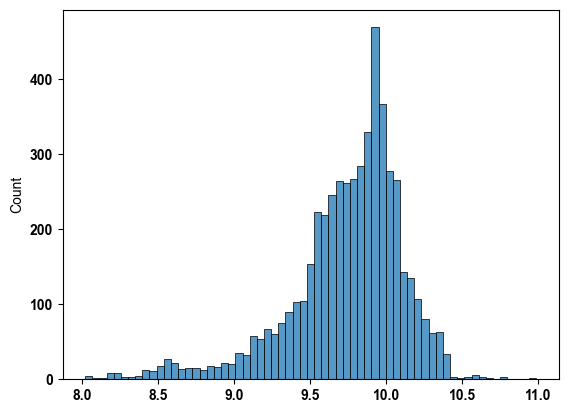

In [9]:
sns.histplot (y)

In [10]:
for s in SMILES:
    if s[-1] != '.':
        print('!error')

In [11]:
SMILES

array(['CCCCCCCC.', 'N#N.', 'C1CC1.', ..., 'CCC(CC)C(F)(F)CC(C)C.',
       'CC(C)CCCCCCC(C)(F)F.', 'CCC(C)CCCC(C)C(F)(F)F.'], dtype=object)

In [12]:
X_smiles_train = np.concatenate ((X_smiles_train_pubqc, X_smiles_train_gen), axis=0)
SMILES_train = np.concatenate ((SMILES_train_pubqc, SMILES_train_gen), axis=0)
y_train = np.concatenate ((y_train_pubqc, y_train_gen), axis=0)
print (y_train.shape)
print (X_smiles_train.shape)

(4168,)
(4168, 40, 27, 1)


In [13]:
for s in SMILES_train:
    if s[-1] != '.':
        print('!error')

In [14]:
X_smiles_test = np.concatenate ((X_smiles_test_pubqc, X_smiles_test_gen), axis=0)
SMILES_test = np.concatenate ((SMILES_test_pubqc, SMILES_test_gen), axis=0)
y_test = np.concatenate ((y_test_pubqc, y_test_gen), axis=0)
print (y_test.shape)
print (X_smiles_test.shape)

(1043,)
(1043, 40, 27, 1)


In [15]:
for s in SMILES_test:
    if s[-1] != '.':
        print('!error')

In [16]:
y_train0 = y_train.copy()
y_test0 = y_test.copy()
y0 = y.copy()

In [17]:
# normalize the gap value between [0-15]
y_train = (y_train0 - 0) / 15
y_test = (y_test0 - 0) / 15
print ('min norm', min(y_train))
print ('min ', min(y_train0))
print ('max norm', max(y_train))
print ('max ', max(y_train0))
print (min(y_test))
print (min(y_test0))
print (max(y_test))
print (max(y_test0))
print ('Average of all: ', np.mean ((np.mean(y_train0), np.mean(y_test0))))

min norm 0.7288943636363636
min  8.017838
max norm 0.9986363636363635
max  10.985
0.729686
8.026546
0.9684545454545455
10.653
Average of all:  9.741833125153182


In [18]:
# standard deviation
(np.std(y_train0) + np.std(y_test0))/2

0.366240993009502

In [19]:
# Encoding to an image embedding
# ENCODER
inp_1 = Input(shape = [40, 27, 1])

y1 = Conv2D(64, (23, 10), strides = 1, padding = 'valid')(inp_1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1 = Conv2D(64, 3, strides = 1, padding = 'valid')(y1)
y1 = LeakyReLU(alpha = 0.2)(y1)
y1 = BatchNormalization()(y1)

y1_emb = Conv2D(1, 3, strides = 1, padding = 'same',
            activation = 'tanh')(y1)

y2 = Conv2D(64, (23, 10), strides = 1, padding = 'valid')(inp_1)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2 = Conv2D(64, 3, strides = 1, padding = 'valid')(y2)
y2 = LeakyReLU(alpha = 0.2)(y2)
y2 = BatchNormalization()(y2)

y2_emb = Conv2D(1, 3, strides = 1, padding = 'same',
                activation = 'tanh')(y2)

####
y_out = Concatenate()([y1_emb, y2_emb])

# DECODER
emb_in = Input(shape = [6, 6, 2])

tower0 = Conv2D(32, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(emb_in)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(emb_in)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(32, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

y = Flatten()(h)

y = Dense(2048, activation = 'relu')(y)
y_cv = Dense(64, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(1024, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(512, activation = 'sigmoid')(y)
y = Dropout(0.2)(y)
y = Dense(40 * 27)(y)
y = Reshape([40, 27, 1])(y)
y = Softmax(axis = 2)(y)


y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dense(1, activation = 'sigmoid')(y_cv)

encoder = Model([inp_1], [y1_emb, y2_emb, y_out], name = 'Encoder')
decoder = Model(emb_in, [y, y_cv], name = 'Decoder')
#print (encoder.summary())
#print (decoder.summary())
outputs = decoder(encoder([inp_1])[2])
#output_2 = decoder(encoder([inp_1])[2])[0]
#output_2 = argmax (output_2, axis=2)
#print (output_2)
#output_2 = Reshape([1, 35])(output_2)

#print (output_2)
# Use IntegerLookup to build an index of the feature values and encode output.
#lookup = IntegerLookup(output_mode="one_hot")
#lookup.adapt(data)
# Convert new test data (which includes unknown feature values)
#outputs = lookup(outputs)
#output_2 = one_hot(output_2, depth=23)


model = Model(inp_1, outputs, name = 'ae')
print (model.summary())

2023-05-19 09:37:05.948567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 09:37:05.948730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 09:37:05.948788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 09:37:05.948990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 09:37:05.949060: I tensorflow/compiler/xla/stream_executo

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 27, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 6, 6, 1),         477442    
                              (None, 6, 6, 1),                   
                              (None, 6, 6, 2)]                   
                                                                 
 Decoder (Functional)        [(None, 40, 27, 1),       15725241  
                              (None, 1)]                         
                                                                 
Total params: 16,202,683
Trainable params: 16,200,571
Non-trainable params: 2,112
_________________________________________________________________
None


In [21]:
encoder.summary(line_length=150)

Model: "Encoder"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 40, 27, 1)]              0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, 18, 18, 64)               14784             ['input_1[0][0]']                                 
                                                                                                                                                      
 conv2d_8 (Conv2D)                               (None, 18, 18, 64)          

In [22]:
# Encoding to an image embedding
# ENCODER
encoder.layers.pop()
encoder.layers.pop()

In [23]:
encoder.summary(line_length=150)

Model: "Encoder"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 40, 27, 1)]              0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, 18, 18, 64)               14784             ['input_1[0][0]']                                 
                                                                                                                                                      
 conv2d_8 (Conv2D)                               (None, 18, 18, 64)          

In [44]:
encoder = load_model('./../data/nns/keep/encoder.h5')
encoder.trainable = False

In [45]:
new_layer1 = Conv2D(1, 3, strides = 1, padding = 'same',
                activation = 'tanh', name='mydense1')

new_layer2 = Conv2D(1, 3, strides = 1, padding = 'same',
                activation = 'tanh', name='mydense2')

inp = encoder.input


out1 = new_layer1(encoder.layers[-4].output)
out2 = new_layer2(encoder.layers[-5].output)

encdoer2_output = Concatenate()([out1, out2])

encoder2 = Model(inp, [out1, out2, encdoer2_output], name='encoder2')
encoder2.summary(line_length=150)

Model: "encoder2"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_3 (InputLayer)                            [(None, 40, 27, 1)]              0                 []                                                
                                                                                                                                                      
 conv2d_60 (Conv2D)                              (None, 18, 18, 64)               14784             ['input_3[0][0]']                                 
                                                                                                                                                      
 conv2d_54 (Conv2D)                              (None, 18, 18, 64)         

In [46]:
inp_1 = Input(shape = [40, 27, 1])
# DECODER
emb_in = Input(shape = [6, 6, 2])

tower0 = Conv2D(32, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 1, padding = 'same')(emb_in)
tower1 = Conv2D(64, 3, padding = 'same')(tower1)
tower2 = Conv2D(32, 1, padding = 'same')(emb_in)
tower2 = Conv2D(32, 5, padding = 'same')(tower2)
tower3 = MaxPooling2D(3, 1, padding = 'same')(emb_in)
tower3 = Conv2D(32, 1, padding = 'same')(tower3)
h = Concatenate()([tower0, tower1, tower2, tower3])
h = ReLU()(h)
h = MaxPooling2D(2, 1, padding = 'same')(h)

for i in range(6):
    tower0 = Conv2D(32, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 1, padding = 'same')(h)
    tower1 = Conv2D(64, 3, padding = 'same')(tower1)
    tower2 = Conv2D(32, 1, padding = 'same')(h)
    tower2 = Conv2D(32, 5, padding = 'same')(tower2)
    tower3 = MaxPooling2D(3, 1, padding = 'same')(h)
    tower3 = Conv2D(32, 1, padding = 'same')(tower3)
    h = Concatenate()([tower0, tower1, tower2, tower3])
    h = ReLU()(h)
    if i % 2 == 0 and i != 0:
        h = MaxPooling2D(2, 1, padding = 'same')(h)
h = BatchNormalization()(h)

y = Flatten()(h)

y = Dense(2048, activation = 'relu')(y)
y_cv = Dense(64, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(1024, activation = 'relu')(y)
y = Dropout(0.2)(y)
y = Dense(512, activation = 'sigmoid')(y)
y = Dropout(0.2)(y)
y = Dense(40 * 27)(y)
y = Reshape([40, 27, 1])(y)
y = Softmax(axis = 2)(y)


y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dropout(0.2)(y_cv)
y_cv = Dense(128, activation = 'relu')(y_cv)
y_cv = Dense(1, activation = 'sigmoid')(y_cv)

#encoder = Model([inp_1], [y1_emb, y2_emb, y_out], name = 'Encoder')
decoder = Model(emb_in, [y, y_cv], name = 'Decoder')
#print (encoder.summary())
#print (decoder.summary())
outputs = decoder(encoder2([inp_1])[2])
#output_2 = decoder(encoder([inp_1])[2])[0]
#output_2 = argmax (output_2, axis=2)
#print (output_2)
#output_2 = Reshape([1, 35])(output_2)

#print (output_2)
# Use IntegerLookup to build an index of the feature values and encode output.
#lookup = IntegerLookup(output_mode="one_hot")
#lookup.adapt(data)
# Convert new test data (which includes unknown feature values)
#outputs = lookup(outputs)
#output_2 = one_hot(output_2, depth=23)


model = Model(inp_1, outputs, name = 'ae')
print (model.summary())

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 27, 1)]       0         
                                                                 
 encoder2 (Functional)       [(None, 6, 6, 1),         558082    
                              (None, 6, 6, 1),                   
                              (None, 6, 6, 2)]                   
                                                                 
 Decoder (Functional)        [(None, 40, 27, 1),       15725241  
                              (None, 1)]                         
                                                                 
Total params: 16,283,323
Trainable params: 15,726,075
Non-trainable params: 557,248
_________________________________________________________________
None


In [47]:
"""
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

encoder = load_model('encoder.h5')
decoder = load_model('decoder.h5')
model = load_model('ae_model.h5')

model.compile(optimizer = Adam(learning_rate = 1e-8),
              loss = ['binary_crossentropy', 'mse'])
history = model.fit([X_atoms_train, X_bonds_train],
                    [X_smiles_train, y_train],
                    validation_data = ([X_atoms_test, X_bonds_test],
                                       [X_smiles_test, y_test]),
                    epochs = 1,
                    batch_size = 32,
                    verbose = 1,
                    callbacks = [lr_schedule])



plt.semilogx(history.history['lr'],
             history.history['val_Decoder_loss'])

encoder = Model([inp_1, inp_2], [y1_emb, y2_emb, y_out], name = 'Encoder')
decoder = Model(emb_in, [y, y_cv], name = 'Decoder')

print (encoder.summary())
print (decoder.summary())

outputs = decoder(encoder([inp_1, inp_2])[2])
model = Model([inp_1, inp_2], outputs, name = 'ae')

model.compile(optimizer = Adam(learning_rate = 9e-5),
              loss = ['binary_crossentropy', 'mse'])

model.fit([X_atoms_train, X_bonds_train],
                    [X_smiles_train, y_train],
                    validation_data = ([X_atoms_test, X_bonds_test],
                                       [X_smiles_test, y_test]),
                    epochs = 1,
                    batch_size = 32,
                    verbose = 1)
"""
"""
try:
    encoder = load_model('./../data/nns/keep/encoder.h5')
    decoder = load_model('./../data/nns/keep/decoder.h5')
    model = load_model  ('./../data/nns/keep/ae_model.h5')
    model.compile(optimizer = Adam(learning_rate = 9e-6),
            loss = ['binary_crossentropy', 'mse'])
    print (".h5 files were read")
except:
    print ("NO .h5 trained files")
    model.compile(optimizer = Adam(learning_rate = 9e-5),
            loss = ['binary_crossentropy', 'mse'])
    pass
"""

#model.load_weights('./../data/nns/ae_model.h5')
#encoder.load_weights('./../data/nns/encoder.h5')
#decoder.load_weights('./../data/nns/decoder.h5')
#encoder = load_model('./../data/nns/encoder.h5')
#decoder = load_model('./../data/nns/decoder.h5')
#model = load_model('./../data/nns/ae_model.h5')
#encoder = load_model('./../data/nns/keep/encoder.h5')
#decoder = load_model('./../data/nns/keep/decoder.h5')
#model = load_model('./../data/nns/keep/ae_model.h5')

#encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
#model = load_model('./../data/nns/keep/ae_model.h5')

encoder.trainable = False
decoder.trainable = True

In [48]:
model.summary()

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 27, 1)]       0         
                                                                 
 encoder2 (Functional)       [(None, 6, 6, 1),         558082    
                              (None, 6, 6, 1),                   
                              (None, 6, 6, 2)]                   
                                                                 
 Decoder (Functional)        [(None, 40, 27, 1),       15725241  
                              (None, 1)]                         
                                                                 
Total params: 16,283,323
Trainable params: 15,726,075
Non-trainable params: 557,248
_________________________________________________________________


In [49]:
# 0.01 gets the best accuracy
model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss = ['binary_crossentropy', 'mse'], loss_weights = [1.0, 1.0],)

history = model.fit(X_smiles_train,
                    [X_smiles_train, y_train],
                    validation_data = (X_smiles_test,
                                       [X_smiles_test, y_test]),
                    epochs=10,
                    batch_size=1,
                    verbose=1)

#model.save  ('./../data/nns/ae_model_trans.h5')
#encoder.save('./../data/nns/encoder_trans.h5')
#decoder.save('./../data/nns/decoder_trans.h5')

tf.compat.v1.keras.backend.clear_session()
# get i and i+2 to have (2,9,10,1) shape
# if only i was chosen, the should be (9,10,1)
output = decoder.predict(encoder2.predict([X_smiles_train[0:2][:][:][:]])[2])[0][0]
output = argmax (output, axis=1)
output = to_categorical (output, num_classes = 27)
print (SMILES_train[0])
print (output.shape)
print ('output of decoder', output)
print (y_train[0])
print (SMILES_test.shape)

Epoch 1/10
1096/1096 [==============================] - 16s 9ms/step - loss: 0.0821 - Decoder_loss: 0.0770 - Decoder_1_loss: 0.0051 - val_loss: 0.0435 - val_Decoder_loss: 0.0425 - val_Decoder_1_loss: 0.0010
Epoch 2/10
1096/1096 [==============================] - 9s 9ms/step - loss: 0.0444 - Decoder_loss: 0.0412 - Decoder_1_loss: 0.0032 - val_loss: 0.0403 - val_Decoder_loss: 0.0394 - val_Decoder_1_loss: 9.3323e-04
Epoch 3/10
1096/1096 [==============================] - 9s 8ms/step - loss: 0.0422 - Decoder_loss: 0.0392 - Decoder_1_loss: 0.0029 - val_loss: 0.0402 - val_Decoder_loss: 0.0377 - val_Decoder_1_loss: 0.0025
Epoch 4/10
1096/1096 [==============================] - 9s 9ms/step - loss: 0.0401 - Decoder_loss: 0.0374 - Decoder_1_loss: 0.0027 - val_loss: 0.0369 - val_Decoder_loss: 0.0356 - val_Decoder_1_loss: 0.0013
Epoch 5/10
1096/1096 [==============================] - 9s 9ms/step - loss: 0.0380 - Decoder_loss: 0.0355 - Decoder_1_loss: 0.0025 - val_loss: 0.0362 - val_Decoder_loss: 0

In [52]:
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
model = load_model('./../data/nns/keep/ae_model.h5')

In [51]:
encoder = load_model('./../data/nns/encoder_trans.h5')
decoder = load_model('./../data/nns/decoder_trans.h5')
model = load_model('./../data/nns/ae_model_trans.h5')

In [24]:
tf.compat.v1.keras.backend.clear_session()

2.114


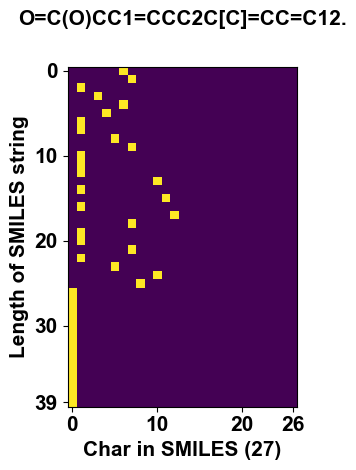

In [21]:

plt.imshow(X_smiles_test[200].reshape([40, 27]), )
plt.title(SMILES_test[200], fontfamily='Arial', fontsize=15, fontweight='bold', pad=30)
plt.xlabel('Char in SMILES (27)', fontfamily='Arial', fontsize=15, fontweight='bold'), 
plt.ylabel('Length of SMILES string', fontfamily='Arial', fontsize=15, fontweight='bold')
plt.xticks((0, 10, 20, 26), size=15)
plt.yticks((0, 10, 20, 30, 39), size=15)
plt.tight_layout()
plt.tight_layout()
plt.savefig('sample_smiles_{}'.format(SMILES_test[200]), dpi=500)
print (y_test0[200])

5 CCCC(C)C(C)CCC.
10 CCCC(C)CCC(C)CCC.
32 CC1CCCCCC(C)CC1.
88 CCC(C)C(C)(C)C.
99 CCC1CCC(C)C1CC.


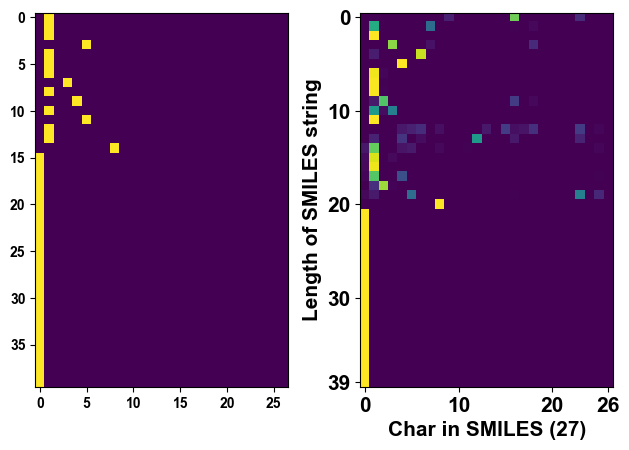

In [50]:
for i in [5, 10, 32, 88, 99]:
    plt.subplot(121)
    plt.imshow(X_smiles_test[i].reshape([40, 27]))
    test_sample_pred = decoder.predict(encoder2.predict([X_smiles_test[i:(i+2)]], verbose=0)[2], verbose=0)[0][0]
    plt.subplot(122)
    plt.imshow(test_sample_pred.reshape([40, 27]))
    plt.xlabel('Char in SMILES (27)', fontfamily='Arial', fontsize=15, fontweight='bold'), 
    plt.ylabel('Length of SMILES string', fontfamily='Arial', fontsize=15, fontweight='bold')
    plt.xticks((0, 10, 20, 26), size=15)
    plt.yticks((0, 10, 20, 30, 39), size=15)
    plt.tight_layout()
    plt.savefig("smiles_{}_test.png".format(i), dpi=500)
    print (i, SMILES_test[i])

In [40]:
tokenizer

{1: 'C',
 2: 'c',
 3: '(',
 4: ')',
 5: '1',
 6: 'O',
 7: '=',
 8: '.',
 9: 'N',
 10: '2',
 11: '[',
 12: ']',
 13: 'n',
 14: '3',
 15: 'H',
 16: 'S',
 17: '-',
 18: '#',
 19: '+',
 20: 's',
 21: 'o',
 22: 'P',
 23: 'F',
 24: '4',
 25: 'l',
 26: 'p',
 0: ' '}

In [28]:
SMILES [SMILES == 'O=c1c2c3ccc([nH]3)c1=C[N]NC=CCC=NC=C=2.']

array([], dtype=object)

In [29]:
X_smiles_test.shape

(275, 40, 27, 1)

In [51]:
# Evaluation: test data
# 0.8113100848256362 valid and true
# 0.8619792648444863  valid
encoder_latent_test = encoder2.predict(X_smiles_test, verbose=0)[2]
decoder_smiles_test = decoder.predict(encoder_latent_test, verbose=0)[0]

dec_SMILES_test = []
for softmax_smiles in decoder_smiles_test:
    argmax_smiles = np.argmax(softmax_smiles, axis=1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_test.append(c_smiles)
    
test_true_conv = sum (SMILES_test == dec_SMILES_test)/len(SMILES_test)
print (test_true_conv)

idxs_test = []
valid_test = 0

for count, smile in enumerate(dec_SMILES_test):
    m = Chem.MolFromSmiles(smile[:-1], sanitize=True)
    if m is not None:
        valid_test += 1
        idxs_test.append(count)

test_valid_conv = valid_test/len(SMILES_test)
print (test_valid_conv)

0.0
0.0036363636363636364


In [27]:
# Evaluation: train data
# 0.8113100848256362 valid and true
# 0.8619792648444863  valid
encoder_latent_train = encoder2.predict(X_smiles_train, verbose=0)[2]
decoder_smiles_train = decoder.predict(encoder_latent_train, verbose=0)[0]

dec_SMILES_train = []
for softmax_smiles in decoder_smiles_train:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_train.append(c_smiles)
    
train_true_conv = sum (SMILES_train == dec_SMILES_train)/len(SMILES_train)
print (train_true_conv)

idxs_train = []
valid_train = 0

for count, smile in enumerate(dec_SMILES_train):
    m = Chem.MolFromSmiles(smile[:-1], sanitize=True)
    if m is not None:
        valid_train += 1
        idxs_train.append(count)

train_valid_conv = valid_train/len(SMILES_train)
print (train_valid_conv)

0.0
0.051094890510948905


In [29]:
# Evaluation: all data
encoder_latent = encoder2.predict(X_smiles, verbose=0)[2]
decoder_smiles = decoder.predict(encoder_latent, verbose=0)[0]

dec_SMILES = []
for softmax_smiles in decoder_smiles:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES.append(c_smiles)
    
true_conv = sum (SMILES == dec_SMILES)/len(SMILES)
print (true_conv)

idxs = []
valid = 0

for count, smile in enumerate(dec_SMILES):
    m = Chem.MolFromSmiles(smile[:-1], sanitize=True)
    if m is not None:
        valid += 1
        idxs.append(count)

valid_conv = valid/len(SMILES)
print (valid_conv)

0.0
0.04814004376367615


In [30]:
true = 0
for s, ds in zip(SMILES, dec_SMILES):
    if s==ds:
        true +=1
print (true/SMILES.shape[0])

0.0


In [31]:
# all data evaluation
# 77.574 valid 
# 71.1124 valid and accurate
valid_conv = (4*train_valid_conv + test_valid_conv)/5
print ('Valid conversion: ', valid_conv)

true_conv = (4*train_true_conv + test_true_conv)/5
print ('Valid and True conversion: ', true_conv)

Valid conversion:  0.048148639681486395
Valid and True conversion:  0.0


In [33]:
def diff_letters(a,b):
    return sum ( a[i] != b[i] for i in range(len(a)) )
# Evaluation: test data
# 98.01629884592023 categorical accuracy
encoder_latent_test = encoder2.predict(X_smiles_test, verbose=0)[2]
decoder_smiles_test = decoder.predict(encoder_latent_test, verbose=0)[0]

dec_SMILES_test = []
for softmax_smiles in decoder_smiles_test:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_test.append(c_smiles)

wrong_char = 0
total_char = 0
for i, j in zip(dec_SMILES_test, SMILES_test):
    try:
        wrong_char = wrong_char + diff_letters(i, j)
    except:
        print(i, j)
    total_char = total_char + len(i) 
print (wrong_char)
print ('% of correct char conv train: ', 100-wrong_char/total_char*100)

CCCCCCC(CCCN(CNCOC1. N#N.
CCOCOCC1CCC11NNC1COC11 CC12CC(C1)C2.
CC(O)C1CC1C11NNCCCC1C1. CC1C2CC1C2C.
O=C11CCCC(C1)N=N1OO(C1 CC(C)C(C)(C)C.
O(=C1CCCC(OC(NO)OC1. CCC(CC)C(CC)CC.
O(=C1CCCC(OC(NN))C1. CCCC(C)C(C)CCC.
OC(CN11CC(=N)NNO)N1. CCCCCCCC(C)(C)C.
OC(COC1OCC(1=NN1OO. CC1CC(C)C1.
OC=C1CCOCCOC(=OC11O. CC1CCCC(C)CCC1.
OC(COC11CCC1)=NO11OC11 CC1CCCCCCCC1.
OC=C1CCcCC(N)N=OOO. CCCC(C)CCC(C)CCC.
CCOC1=NCCCCC1C1ccccc1(. C1CC2C3CC(C3)C2C1.
CC1COCCOCCN1C1nCOcn1C. CC1OC1OC1OC1C.
CC(C1c1ccc(C)NNOO). CCCCC(CC)C(C)CCC.
CC=C1CCO)(OC(NN)O1. CCC(CC)C1CCCC1.
C(=CCCCN1CCC(=NNNC1.C. CCCC1CCC(C)C1C.
CCOCOCC1CCC11nnCnc. CCC1OCOCO1.
CC1CCCCCCCC1)CNNNC. COC1OC1C.
OC=c1ccc1C(O)NOOO1Occ1. CCCCCCCCCC(C)C(C)CC.
O(CC(CCO1C(1)OOOO)1CC11C11C CCCCCCCCCCCCC.
CC1CNCcNCcc1)NNc1cOc1. CC12CC(C1)C(C)(C)C2.
OC1CNCCC1(CN)=O)OC1.C. CCCC1CCC(C)C1CC.
OCCC1CCC1C11(N=C(O)(C. CC(C)C(C)C.
CC(C1C(C)((N)C)O)C. C1CCCCC1.
OC(COCCCC(CC)NOCOCCCC1. CCCCC1CCCC1.
C(CCOCC1CCCC1NNN11O. CCC1CCC(CC)C1.
OC(C1CC1CC(1=NNOOOOCCCC CCCCC(C)CC.
O(=C

In [35]:
# Evaluation: train data
#  99.98139237365801 categorical accuracy
encoder_latent_train = encoder2.predict(X_smiles_train, verbose=0)[2]
decoder_smiles_train = decoder.predict(encoder_latent_train, verbose=0)[0]

dec_SMILES_train = []
for softmax_smiles in decoder_smiles_train:
    argmax_smiles = np.argmax(softmax_smiles, axis = 1).reshape([-1])
    #print (argmax_smiles)
    smiles = to_categorical(argmax_smiles, num_classes=27)
    SHAPE = [1] + list(smiles.shape) + [1]
    smiles = smiles.reshape(SHAPE)
    c_smiles = ''
    for s in argmax_smiles:
        c_smiles += tokenizer[s]
        c_smiles = c_smiles.rstrip()
    dec_SMILES_train.append(c_smiles)

wrong_char = 0
total_char = 0
for i, j in zip(dec_SMILES_train, SMILES_train):
    try:
        wrong_char = wrong_char + diff_letters(i, j)
    except:
        print(i, j)
    total_char = total_char + len(i) 
print ('% of correct char conv train: ', 100-wrong_char/total_char*100)

OCCCNCC1CCC1(NNN1OOCC1 CCCCCC(C)CCC.
OC(CNCCCCCC1(=OO1O1. CCCC(C)(C)CC.
OCCC11CCCC(1=NNOOO. C1CCCCCCC1.
CC(CO)1NCCOCCNNC1CCC11. CC1CC2CC1C2C.
C(=C1CCCC(CC)NNO)C1. CCCC(C)C(C)CC.
OC=COCC1CCC1)NON11O. CCC1CCC(C)C1C.
CC(COC1CC(OC)NNNOC)C11. CCCCC1CCCC1C.
C(CCNC1CC(CC)NOONC1.CC CCC(C)CC(C)CC.
CC(CCC1OCC(C)=ON11. CCC1CCCC2CCCC12.
OC=C1CCCC(=N)N=O)C1. CCCC(C)C(CC)CCC.
O(CC1CCC1COC(NOO11.C. CC(C)CCCC1CCC1.
OC(C1CCO1CC1)OOOO)OCC1.1 CCCCCCCCCCCC.
OC1CNCCOC(C1)=OC11.. CC1CC(C(C)C)C1.
O(=CNCC1C(OC(NOc11Occ. CCCCCC(CCC)CC(C)CC.
OC(C1cccccc1)CNOOO.. CCC1(CC)CCC(C)C1.
O(CC1C1CC(C1)NNOO)O1C1. CCCCC(C)C(C)C.
CCOC1CCNCCOCCNCC11. CC1CC2CC1C1CCCC21.
CC(CCCC11CC1(NNOOC1CC. CCCC1CCC1C.
CC1CCCCCCCCc1cccncc1C. C1OC2(O1)OCO2.
OCCC1CC1C(C1(NOOO)O1C. CC(C)CCCC(C)C(C)C.
OC(C1CC1CCC1(NNO1OO)C1 CCCCCC(C)CC.
OC=COCCC1CC1(NOC1(O) CC(C)CC(C)C.
OC=C1CCCC(CO)=OON11. CCCC(C)(CCC)CCC.
OCCC1ccncc(C(NNOO)O.c CCCCCCCCC(CCC)CCC.
CCCC1C1OCC(C)NNOO). CCCCCCCC1CCCCCC1.
OC1CNcc1CCC1)NNNOc1cc1 CCC1CCCC(CC)CC(CC)C1.
OC=C1Cc1C(C1=N

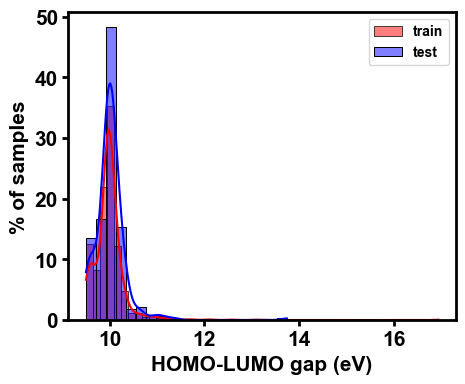

In [36]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.tick_params(axis='both', length=4, width=2, colors='black', grid_alpha=0, labelsize=15)
[i.set_linewidth(2) for i in ax.spines.values()]
plt.xlabel('HOMO-LUMO gap (eV)', fontname='Arial', fontweight = 'bold', fontsize=15)
plt.ylabel('% of samples', fontname='Arial', fontweight = 'bold', fontsize=15)

sns.histplot (y_train0, color='red', label='train', stat='percent', kde=True, bins=50)
sns.histplot (y_test0, color='blue', label='test', stat='percent', kde=True, bins=20, alpha=0.5)
plt.legend()

In [40]:
smiles_conv = pd.DataFrame({})
smiles_conv ['true_SMILES'] = SMILES
smiles_conv ['conv_SMILES'] = np.array (dec_SMILES)

In [41]:
smiles_conv_test = pd.DataFrame({})
smiles_conv_test ['true_SMILES'] = SMILES_test
smiles_conv_test ['conv_SMILES'] = np.array (dec_SMILES_test)

In [42]:
# wrong conversion
wrong_idx = smiles_conv_test.loc[smiles_conv_test ['true_SMILES'] != smiles_conv_test ['conv_SMILES']].index.to_list()

In [43]:
wrong_idx

[179,
 185,
 206,
 209,
 210,
 217,
 219,
 224,
 226,
 229,
 234,
 236,
 237,
 238,
 242,
 243,
 248,
 254,
 258,
 266]